In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import re
import matplotlib.pyplot as plt
import tensorflow
import string

pd.options.mode.chained_assignment = None 

In [2]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
lemmatizer = WordNetLemmatizer() 

[nltk_data] Downloading package punkt to /home/feem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/feem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/feem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/feem/miniconda3/envs/nlp/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [79]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.ensemble import RandomForestClassifier

import tensorflow.keras.preprocessing.sequence as ps
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Embedding,Dropout


from keras.layers import GlobalAveragePooling1D


In [35]:
dataset = pd.read_csv('tweets.csv')
train_data = dataset.sample(frac=0.9, random_state=25)
test_data = dataset.drop(train_data.index)


In [36]:
test_data.shape

(410, 8)

In [37]:
train_data.head()

,tweet,twitterHandlerused,label,fasttext_labels,Comparison_human&ft,Labels_Manish_Krishna_Anu_Harvinder,2nd review,Final_labels
2914,@Vishen @mindvalley @SadhguruJV Eagerly waitin...,@mindvalley,Neutral,Neutral,NaN,NaN,NaN,Neutral
2038,"@TonyRobbins Hey, guys! I created a YouTube ch...",@tonyrobbins,Neutral,Neutral,NaN,NaN,NaN,Neutral
3785,@HSBC_UK I have been on hold and spoken to 3 a...,HSBC_UK,Negative,Negative,NaN,NaN,NaN,Negative
2322,RT @johnassaraf: The moment you change your pe...,@johnassaraf,Neutral,Neutral,NaN,NaN,NaN,Neutral
3244,Enjoyed this conversation with @mindvalley on ...,@mindvalley,Neutral,Neutral,NaN,NaN,NaN,Neutral


In [38]:
test_data.head()

,tweet,twitterHandlerused,label,fasttext_labels,Comparison_human&ft,Labels_Manish_Krishna_Anu_Harvinder,2nd review,Final_labels
10,@mindvalley At last!! The moment I've been wai...,@mindvalley,Positive,Positive,NaN,NaN,NaN,Positive
14,RT @mindvalley: ÃƒÂ°Ã…Â¸Ã¢â‚¬ËœÃ¢â‚¬Â¡ Let us ...,@mindvalley,Neutral,Neutral,NaN,NaN,NaN,Neutral
20,@mindvalley You are the best,@mindvalley,Positive,Positive,NaN,NaN,NaN,Positive
22,You all better join the FREE @mindvalley SUMMI...,@mindvalley,Neutral,Neutral,NaN,NaN,NaN,Neutral
25,@AstroGann33 @mindvalley Lucid dreams since yo...,@mindvalley,Positive,Positive,NaN,NaN,NaN,Positive


In [39]:
train_data.drop(['twitterHandlerused', 'Final_labels', 'fasttext_labels', 'Comparison_human&ft', 'Labels_Manish_Krishna_Anu_Harvinder', '2nd review'],axis=1,inplace=True)
test_data.drop( ['twitterHandlerused', 'Final_labels', 'fasttext_labels', 'Comparison_human&ft', 'Labels_Manish_Krishna_Anu_Harvinder', '2nd review'],axis=1,inplace=True)

In [40]:
train_data.head()

,tweet,label
2914,@Vishen @mindvalley @SadhguruJV Eagerly waitin...,Neutral
2038,"@TonyRobbins Hey, guys! I created a YouTube ch...",Neutral
3785,@HSBC_UK I have been on hold and spoken to 3 a...,Negative
2322,RT @johnassaraf: The moment you change your pe...,Neutral
3244,Enjoyed this conversation with @mindvalley on ...,Neutral


In [41]:

def data_cleaning(data):
    cleaned_data = []
    fillerWord = ("so","yeah","okay","um","uh","mmm","ahan","uh","huh","ahm","oh","sooo","uh","huh","yeh","yah","hmm","bye")
    fillerword_reg= "bye[.,]|so[.,]|yeah[.,]|okay[.,]|um[.,]|uh[.,]|mmm[.,]|ahan[.,]|uh[.,]|huh[.,]|ahm[.,]|oh[.,]|sooo[.,]|uh[.,]|huh[.,]|yeh[.,]|yah[.,]|hmm[.,]"
    STOPWORDS = set(stopwords.words('english'))
    remove=["doesn't","not","nor","neither","isn't","hadn't","mightn't","needn't","wasn't"]
    for i in remove:
        STOPWORDS.discard(i)
    
    STOPWORDS.add(fillerWord)
    for i in range(len(data)):
        tweet = re.sub("#", "", data[i])
        tweet = re.sub(r'^https?:\/\/.*[\r\n]*', '',tweet, flags=re.MULTILINE)
        html=re.compile(r'<.*?>')
        tweet =html.sub(r"", tweet)
        tweet=re.sub(r'@\w+',"",tweet)
        tweet=re.sub(r'#\w+',"",tweet) 
        tweet=re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', tweet) 
        punctuation = r"""!"$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
        tweet.rstrip(string.punctuation)
        tweet=re.sub('[^A-Za-z\s]+',"", tweet)
        tweet = tweet.lower()
        tweet = tweet.split()
        #Lemmatization to normalise text
        tweet = [lemmatizer.lemmatize(word) for word in tweet if not word in STOPWORDS]
        tweet = ' '.join(tweet)
        filler=re.compile(fillerword_reg)
        tweet=filler.sub("",tweet)
        cleaned_data.append(tweet)
    return cleaned_data

In [42]:
train_data.head()

,tweet,label
2914,@Vishen @mindvalley @SadhguruJV Eagerly waitin...,Neutral
2038,"@TonyRobbins Hey, guys! I created a YouTube ch...",Neutral
3785,@HSBC_UK I have been on hold and spoken to 3 a...,Negative
2322,RT @johnassaraf: The moment you change your pe...,Neutral
3244,Enjoyed this conversation with @mindvalley on ...,Neutral


In [43]:
train_data

,tweet,label
2914,@Vishen @mindvalley @SadhguruJV Eagerly waitin...,Neutral
2038,"@TonyRobbins Hey, guys! I created a YouTube ch...",Neutral
3785,@HSBC_UK I have been on hold and spoken to 3 a...,Negative
2322,RT @johnassaraf: The moment you change your pe...,Neutral
3244,Enjoyed this conversation with @mindvalley on ...,Neutral
...,...,...
2578,"@STELLJUNparin @SB19Official 78\n\n""The only i...",Neutral
1289,The past does not equal the future. - @TonyRob...,Neutral
1281,"I am jumping, writing, and working with @TonyR...",Neutral
3162,@mindvalley Actually....why to discuss about w...,Neutral


In [44]:
texto_data=train_data['tweet'].tolist()
process_text=data_cleaning(texto_data)

cleaned_tweet =pd.DataFrame(process_text)
train_data = train_data.assign(CleanedTweet=cleaned_tweet.values)

train_data.head()

,tweet,label,CleanedTweet
2914,@Vishen @mindvalley @SadhguruJV Eagerly waitin...,Neutral,eagerly waiting
2038,"@TonyRobbins Hey, guys! I created a YouTube ch...",Neutral,hey guy created youtube channel marketing stra...
3785,@HSBC_UK I have been on hold and spoken to 3 a...,Negative,hold spoken agent hour morning transferred lin...
2322,RT @johnassaraf: The moment you change your pe...,Neutral,rt moment change perception moment rewrite che...
3244,Enjoyed this conversation with @mindvalley on ...,Neutral,enjoyed conversation never make bad decision c...


In [45]:
texto_data=test_data['tweet'].tolist()
process_text=data_cleaning(texto_data)

cleaned_tweet =pd.DataFrame(process_text)
test_data = test_data.assign(CleanedTweet=cleaned_tweet.values)

test_data.head()

,tweet,label,CleanedTweet
10,@mindvalley At last!! The moment I've been wai...,Positive,last moment ive waiting thank thank excited se...
14,RT @mindvalley: ÃƒÂ°Ã…Â¸Ã¢â‚¬ËœÃ¢â‚¬Â¡ Let us ...,Neutral,rt let u know excited mindvalleysummit best co...
20,@mindvalley You are the best,Positive,best
22,You all better join the FREE @mindvalley SUMMI...,Neutral,better join free summit happening thth june
25,@AstroGann33 @mindvalley Lucid dreams since yo...,Positive,lucid dream since young age went away came bac...


In [46]:
X_train = train_data.CleanedTweet
Y_train = train_data.label

In [47]:
Y_train = train_data.label
Y_train.shape

(3694,)

In [48]:
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)

In [49]:
Y_train = pd.DataFrame(Y_train,columns=['label'])
Y_train.head()

,label
0,1
1,1
2,0
3,1
4,1


In [50]:
test_data.head()

,tweet,label,CleanedTweet
10,@mindvalley At last!! The moment I've been wai...,Positive,last moment ive waiting thank thank excited se...
14,RT @mindvalley: ÃƒÂ°Ã…Â¸Ã¢â‚¬ËœÃ¢â‚¬Â¡ Let us ...,Neutral,rt let u know excited mindvalleysummit best co...
20,@mindvalley You are the best,Positive,best
22,You all better join the FREE @mindvalley SUMMI...,Neutral,better join free summit happening thth june
25,@AstroGann33 @mindvalley Lucid dreams since yo...,Positive,lucid dream since young age went away came bac...


In [51]:
X_test = test_data.CleanedTweet
Y_test = test_data.label

In [52]:
X_test.head()
Y_test.head()

10    Positive
14     Neutral
20    Positive
22     Neutral
25    Positive
Name: label, dtype: object

In [53]:
Y_test = encoder.fit_transform(Y_test)


In [54]:
Y_test = pd.DataFrame(Y_test,columns=['label'])

In [55]:
Y_test.head()


,label
0,2
1,1
2,2
3,1
4,2


In [56]:
vectorizer = CountVectorizer(max_features= 3000, min_df = 3, max_df = 0.6)
X_train_data = vectorizer.fit_transform(X_train)
X_train_data.shape

(3694, 2205)

In [57]:
X_test_data = vectorizer.fit_transform(X_test)

In [58]:
X_train_data.shape


(3694, 2205)

In [59]:
Y_train.shape

(3694, 1)

In [60]:
transformer = TfidfTransformer()
X_train_data = transformer.fit_transform(X_train_data).toarray()

print(X_train_data.shape)

(3694, 2205)


In [61]:
Y_train.head()

,label
0,1
1,1
2,0
3,1
4,1


In [62]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_train_data, Y_train, test_size=0.33,random_state = 15)

In [63]:
model1_nb = MultinomialNB()
y_train_pred = model1_nb.fit(X1_train,y1_train.label).predict(X1_train)

y_pred = model1_nb.predict(X1_test)
  
print(metrics.accuracy_score(y1_train, y_train_pred)*100)
print(metrics.accuracy_score(y1_test, y_pred)*100)

83.10428455941795
75.81967213114754


In [64]:
gboost_m = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
train_pred = gboost_m.fit(X1_train,y1_train.label).predict(X1_train)
prediction = gboost_m.score(X1_test,y1_test )
print(accuracy_score(y1_train, train_pred)*100 )
print(prediction*100)

94.0986257073565
76.55737704918033


In [65]:
rf_model=RandomForestClassifier()
train_pred = rf_model.fit(X1_train,y1_train.label).predict(X1_train)
prediction = rf_model.score(X1_test,y1_test )
print(metrics.accuracy_score(y1_train, train_pred)*100 )
print(prediction*100)


99.23201293451899
81.14754098360656


In [66]:
rf_model=RandomForestClassifier(n_estimators=300,min_samples_split = 10,min_samples_leaf = 8)
train_pred = rf_model.fit(X1_train,y1_train.label).predict(X1_train)
prediction = rf_model.score(X1_test,y1_test)
print(metrics.accuracy_score(y1_train, train_pred)*100)
print(prediction*100)

77.72837510105093
75.81967213114754


In [67]:
print("X_train\n",X_train.head())
print("Y_train\n",Y_train.head())

print("X_test\n",X_test.head())
print("Y_test\n",Y_test.head())

X_train
 2914                                      eagerly waiting
2038    hey guy created youtube channel marketing stra...
3785    hold spoken agent hour morning transferred lin...
2322    rt moment change perception moment rewrite che...
3244    enjoyed conversation never make bad decision c...
Name: CleanedTweet, dtype: object
Y_train
    label
0      1
1      1
2      0
3      1
4      1
X_test
 10    last moment ive waiting thank thank excited se...
14    rt let u know excited mindvalleysummit best co...
20                                                 best
22          better join free summit happening thth june
25    lucid dream since young age went away came bac...
Name: CleanedTweet, dtype: object
Y_test
    label
0      2
1      1
2      2
3      1
4      2


In [68]:
tokenizer = Tokenizer(num_words=50000,
                      lower=True,
                      split=' ',
                      char_level=False,
                      oov_token='<UNK>',
                      document_count=0)

In [69]:
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(Y_train)

wordindex=tokenizer.word_index

In [70]:
tokenizer_config = tokenizer.get_config()
tokenizer_config.keys()

dict_keys(['num_words', 'filters', 'lower', 'split', 'char_level', 'oov_token', 'document_count', 'word_counts', 'word_docs', 'index_docs', 'index_word', 'word_index'])

In [73]:
max_length = 50
train_sequence = tokenizer.texts_to_sequences(X_train)
train_padding = ps.pad_sequences(train_sequence,maxlen=max_length,padding='post')

test_sequence = tokenizer.texts_to_sequences(X_test)
test_padding = ps.pad_sequences(test_sequence,maxlen=max_length,padding='post')

In [74]:
train_padding.shape
Y_train.shape

(3694, 1)

In [75]:
y_train = OneHotEncoder().fit_transform(Y_train)

In [76]:
y_train.shape
y_test = OneHotEncoder().fit_transform(Y_test)
y_test.shape

(410, 3)

In [80]:
base_model = Sequential()
base_model.add(Embedding(50000,128,input_length=train_padding.shape[1]))
base_model.add(GlobalAveragePooling1D())
base_model.add(Dense(8,activation='relu'))
base_model.add(Dense(3,activation='softmax'))

In [81]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 128)           6400000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 6,401,059
Trainable params: 6,401,059
Non-trainable params: 0
_________________________________________________________________


In [82]:
base_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [83]:
y_train=np.array(y_train.toarray())

In [84]:
train_padding=np.array(train_padding)

In [85]:
history_base = base_model.fit(train_padding,y_train ,epochs=10, validation_split=0.2)

2022-01-11 10:43:39.842701: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-11 10:43:39.862716: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994345000 Hz


Epoch 1/10
93/93 [==============================] - 5s 51ms/step - loss: 0.9798 - accuracy: 0.6705 - val_loss: 0.8194 - val_accuracy: 0.6712
Epoch 2/10
93/93 [==============================] - 4s 47ms/step - loss: 0.8447 - accuracy: 0.6472 - val_loss: 0.7981 - val_accuracy: 0.6712
Epoch 3/10
93/93 [==============================] - 4s 48ms/step - loss: 0.7905 - accuracy: 0.6582 - val_loss: 0.7687 - val_accuracy: 0.6712
Epoch 4/10
93/93 [==============================] - 4s 43ms/step - loss: 0.7415 - accuracy: 0.6528 - val_loss: 0.7231 - val_accuracy: 0.6712
Epoch 5/10
93/93 [==============================] - 4s 45ms/step - loss: 0.6502 - accuracy: 0.6779 - val_loss: 0.6535 - val_accuracy: 0.7009
Epoch 6/10
93/93 [==============================] - 4s 47ms/step - loss: 0.5195 - accuracy: 0.7827 - val_loss: 0.5880 - val_accuracy: 0.7645
Epoch 7/10
93/93 [==============================] - 4s 45ms/step - loss: 0.4362 - accuracy: 0.8434 - val_loss: 0.5965 - val_accuracy: 0.7402
Epoch 8/10
93

(0.0, 0.9560176350176335)

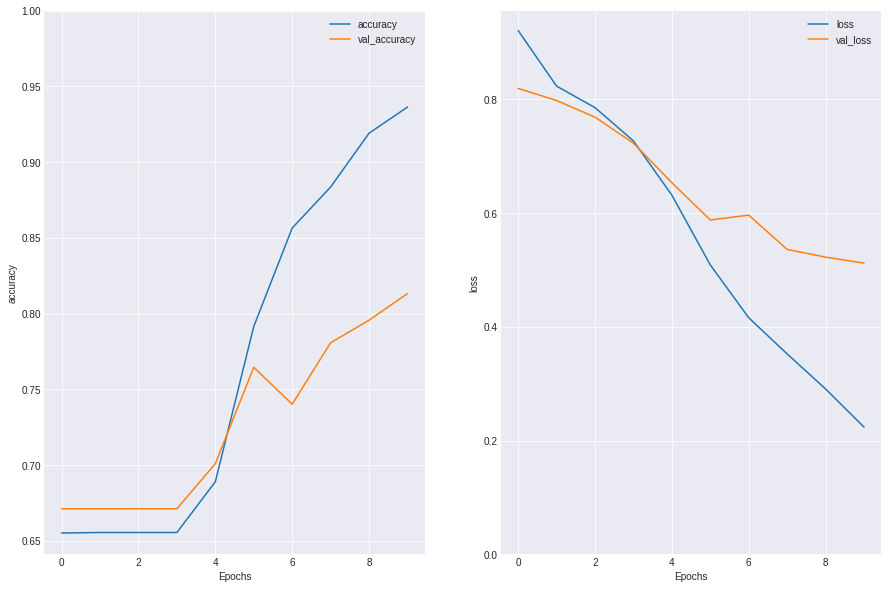

In [86]:
plt.style.use('seaborn-darkgrid')
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history_base, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_base, 'loss')
plt.ylim(0, None)

In [87]:
regularise = tensorflow.keras.regularizers.l2(0.001)

model_r = Sequential()
model_r.add(Embedding(50000,128,input_length=train_padding.shape[1]))
model_r.add(Dropout(0.5))
model_r.add(GlobalAveragePooling1D())
model_r.add(Dense(8,activation='relu',kernel_regularizer=regularise))
model_r.add(Dropout(0.5))
model_r.add(Dense(3,activation='softmax'))
model_r.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 128)           6400000   
_________________________________________________________________
dropout (Dropout)            (None, 50, 128)           0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 6,401,059
Trainable params: 6,401,059
Non-trainable params: 0
____________________________________________

In [88]:
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 128)           6400000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 6,401,059
Trainable params: 6,401,059
Non-trainable params: 0
_________________________________________________________________


In [89]:
model_r.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [90]:
history_r = model_r.fit(train_padding,y_train ,epochs=8, validation_split=0.2)

Epoch 1/8
93/93 [==============================] - 5s 51ms/step - loss: 1.0337 - accuracy: 0.6382 - val_loss: 0.8685 - val_accuracy: 0.6712
Epoch 2/8
93/93 [==============================] - 5s 54ms/step - loss: 0.9010 - accuracy: 0.6571 - val_loss: 0.8383 - val_accuracy: 0.6712
Epoch 3/8
93/93 [==============================] - 5s 51ms/step - loss: 0.8931 - accuracy: 0.6402 - val_loss: 0.8222 - val_accuracy: 0.6712
Epoch 4/8
93/93 [==============================] - 5s 54ms/step - loss: 0.8363 - accuracy: 0.6665 - val_loss: 0.7968 - val_accuracy: 0.6712
Epoch 5/8
93/93 [==============================] - 5s 55ms/step - loss: 0.8122 - accuracy: 0.6614 - val_loss: 0.7694 - val_accuracy: 0.6712
Epoch 6/8
93/93 [==============================] - 5s 55ms/step - loss: 0.7585 - accuracy: 0.6548 - val_loss: 0.7437 - val_accuracy: 0.6712
Epoch 7/8
93/93 [==============================] - 5s 53ms/step - loss: 0.7261 - accuracy: 0.6622 - val_loss: 0.7278 - val_accuracy: 0.6712
Epoch 8/8
93/93 [===

(0.0, 0.9924438685178757)

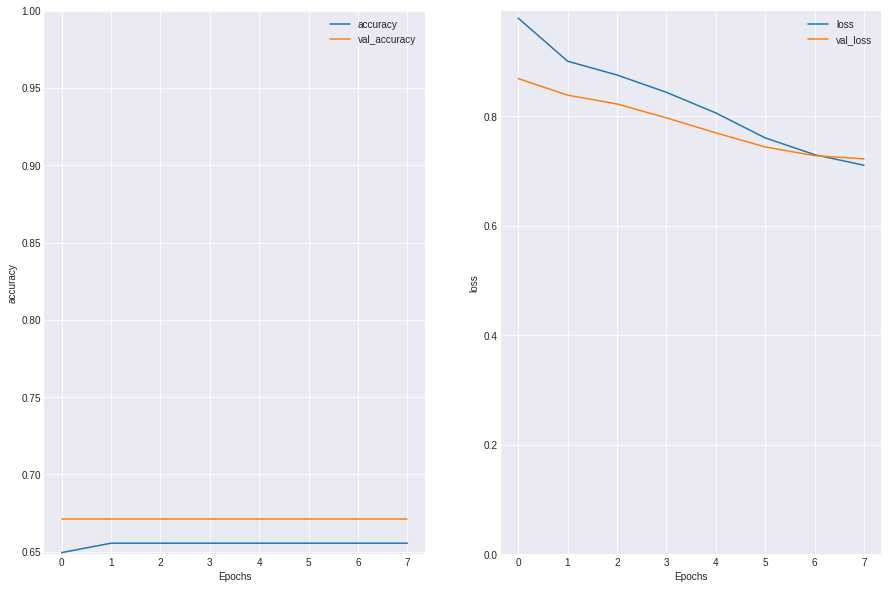

In [91]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plot_graphs(history_r, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_r, 'loss')
plt.ylim(0, None)

In [92]:
score = model_r.evaluate(test_padding,y_test.toarray()) 
print("Testing Accuracy(%): ", score[1]*100)

13/13 [==============================] - 0s 3ms/step - loss: 0.7628 - accuracy: 0.6512
Testing Accuracy(%):  65.12194871902466


In [93]:
y_pred = model_r.predict(test_padding)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in y_test])